In [1]:
# import libraries

from tensorflow.keras.layers import Input,Dense,Dropout,Flatten,GlobalAveragePooling2D

from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input

from tensorflow.keras.applications.xception import Xception,preprocess_input

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

import tensorflow as tf

from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.models import Sequential,Model

import seaborn as sns 

from tensorflow.keras.models import load_model

from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import *

import matplotlib.cm as cm

import warnings

warnings.filterwarnings('ignore')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# using the pretrained model and its weights

IMAGE_SIZE=[224,224]
base_model=Xception(input_shape=IMAGE_SIZE + [3],weights='imagenet',include_top=False)

last_conv_layer_name = "block14_sepconv2_act"

for layer in base_model.layers[:-8]:
    layer.trainable=False

In [4]:
# creating a functional api model

new_model = base_model.output
new_model = GlobalAveragePooling2D()(new_model)
new_model = Dense(2,activation='softmax')(new_model)

model=Model(base_model.input,new_model)

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                             

In [6]:
# image augmentation of train data 

train_datagen=ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# rescaling of validation and test data
val_datagen=ImageDataGenerator(rescale=1./255)

test_datagen=ImageDataGenerator(rescale=1./255)

In [7]:
# taking train data from its path

training_set=train_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/train/',
                                              target_size=(224,224),
                                              batch_size=64,
                                              class_mode='categorical',
                                              shuffle=True)

Found 5310 images belonging to 2 classes.


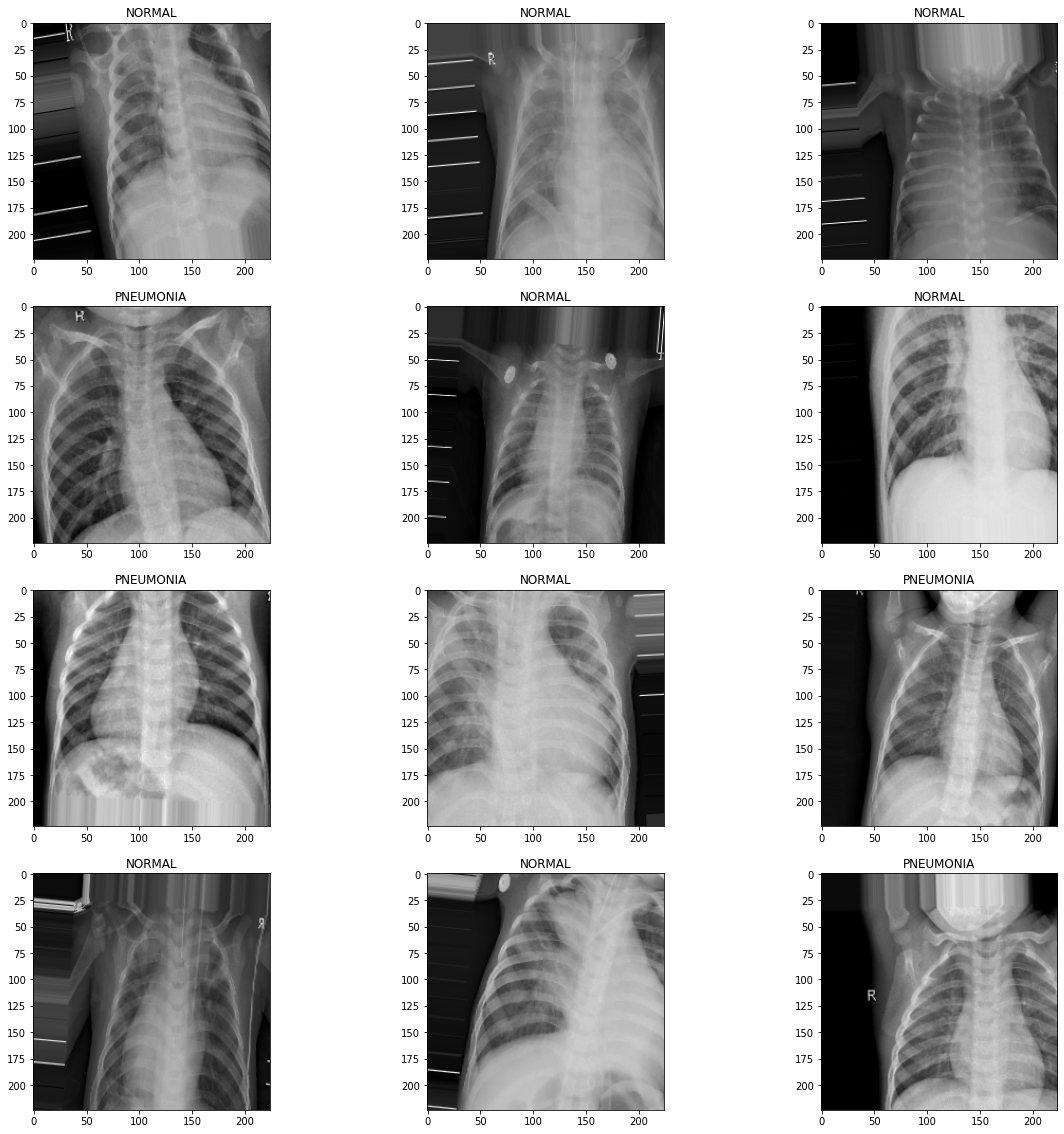

In [8]:
# plotting the augmented images

augmented = next(training_set)
fig = plt.figure(figsize=(20,20))
for i in range(len(augmented[0]))[:12]:
    img = augmented[0][i]
    label = augmented[1][i]
    plt.subplot(4,3,i+1)
    plt.imshow(img)
    if label[[0]]== 0:
        plt.title("NORMAL")
    else:
        plt.title("PNEUMONIA")

In [9]:
# taking validation data from its path

validation_set=val_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/val',
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              batch_size=64) 

Found 16 images belonging to 2 classes.


In [10]:
# taking test data from its path

test_set=test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test/',
                                              target_size=(224,224),
                                              class_mode='categorical',
                                              batch_size=64)

Found 624 images belonging to 2 classes.


In [11]:
# early stopping and model checkpoint

early_stop= EarlyStopping(monitor='val_loss',
                          patience=10,
                           restore_best_weights=True,
                           mode='min')

mc = ModelCheckpoint(monitor='val_loss',
                           patience=10,
                           filepath='./pneumonia_xception.h5',
                           save_best_only=True,
                           mode='min')

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"])

In [12]:
# training the model

result=model.fit(training_set,
                 validation_data=validation_set,
                 epochs=30,
                 callbacks=[early_stop,mc],
                 steps_per_epoch=32,
                 validation_steps=1)

Epoch 1/30
32/32 [==============================] - 77s 2s/step - loss: 0.2302 - accuracy: 0.8920 - val_loss: 1.1089 - val_accuracy: 0.6875
Epoch 2/30
32/32 [==============================] - 57s 2s/step - loss: 0.1365 - accuracy: 0.9492 - val_loss: 0.4758 - val_accuracy: 0.8125
Epoch 3/30
32/32 [==============================] - 56s 2s/step - loss: 0.1389 - accuracy: 0.9501 - val_loss: 1.4644 - val_accuracy: 0.5625
Epoch 4/30
32/32 [==============================] - 57s 2s/step - loss: 0.1200 - accuracy: 0.9580 - val_loss: 0.3677 - val_accuracy: 0.7500
Epoch 5/30
32/32 [==============================] - 55s 2s/step - loss: 0.1016 - accuracy: 0.9629 - val_loss: 0.7013 - val_accuracy: 0.6875
Epoch 6/30
32/32 [==============================] - 55s 2s/step - loss: 0.0991 - accuracy: 0.9609 - val_loss: 1.3035 - val_accuracy: 0.6875
Epoch 7/30
32/32 [==============================] - 55s 2s/step - loss: 0.0904 - accuracy: 0.9692 - val_loss: 1.0122 - val_accuracy: 0.7500
Epoch 8/30
32/32 [==

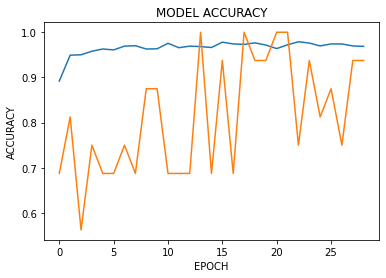

In [13]:
# plotting the model accuracy

plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('MODEL ACCURACY')
plt.ylabel('ACCURACY')
plt.xlabel('EPOCH')
plt.show()

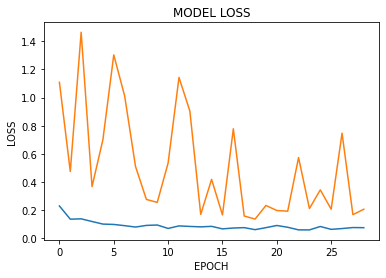

In [14]:
# plotting the model loss

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('MODEL LOSS')
plt.ylabel('LOSS')
plt.xlabel('EPOCH')
plt.show()

In [15]:
# evaluating the model on the test data

model.evaluate(test_set)[1] 


10/10 [==============================] - 350s 39s/step - loss: 0.1782 - accuracy: 0.9279


0.9278846383094788

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       234
           1       0.95      0.94      0.94       390

    accuracy                           0.93       624
   macro avg       0.92      0.93      0.92       624
weighted avg       0.93      0.93      0.93       624



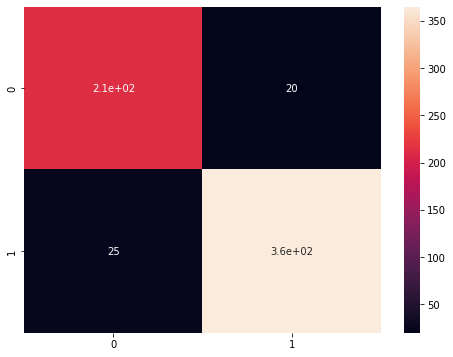

In [16]:
# displaying confusion matrix and classification report

y_true=test_set.classes[test_set.index_array] 
y_pred=np.argmax(model.predict(test_set),axis=1)


plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true,y_pred),annot=True)
print(classification_report(y_true,y_pred))

In [17]:
# printing auc score

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc = auc(fpr, tpr)
print('AUC = ',auc)

AUC =  0.9252136752136751


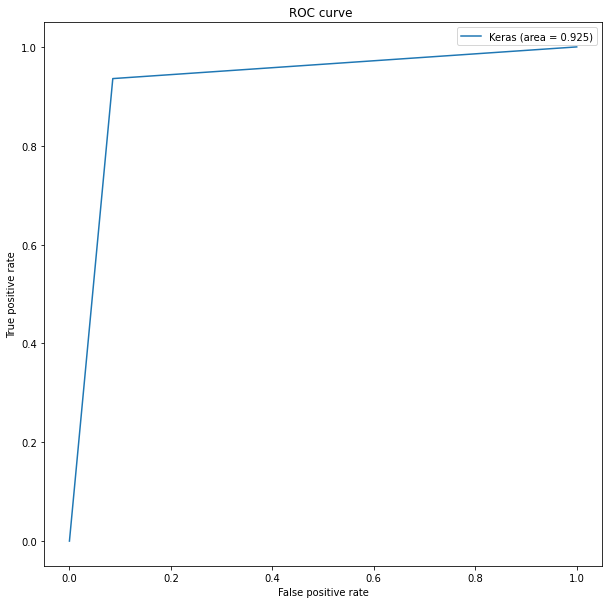

In [18]:
# plotting roc curve

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve ')
plt.legend(loc='best')
plt.show()

In [19]:
# converting image to array

def get_img_array(img_path, size):
    img = load_img(img_path, target_size=(224,224,3))
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# function for grad cam

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model=Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

  

In [20]:
# function for predicting the image and displaying the grad cam

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):

    img = load_img(img_path)
    img = img_to_array(img)
    image =img / 255.0
    image = np.expand_dims(img, axis=0)
    prediction=model.predict(image)
    if(prediction[0][0] > 0.5):
      stat = prediction[0][0] * 100
      message="This image is %.2f percent %s"% (stat, "NORMAL")
      print(message)

    else:
      stat = (1.0 - prediction[0][0]) * 100
      message = "This image is %.2f percent %s" % (stat, "PNEUMONIA")
      print(message)
    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(superimposed_img)


This image is 100.00 percent PNEUMONIA


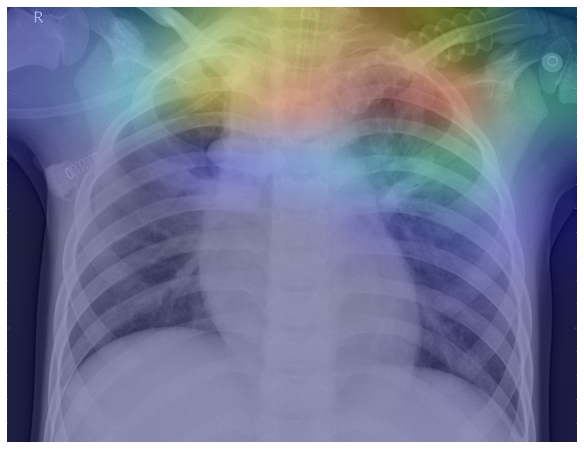

In [21]:
filename='/content/drive/MyDrive/chest_xray/test/PNEUMONIA/person10_virus_35.jpeg'

img_array = preprocess_input(get_img_array(filename, size=(224,224)))

preds = model.predict(img_array)

heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

save_and_display_gradcam(filename, heatmap)